# Getting Started

This notebook is for data annotation


Before starting, if you want to annotate yourself, make sure you have downloaded the original scanned images and it sits at the same directory as the main project.

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import shutil

In [2]:
os.chdir("../..")  # left the project folder

In [3]:
images_folder = r"./armenian_handwrtings_data_collection"

In [ ]:
os.listdir(images_folder)

In [13]:
image_path = os.path.join(images_folder, "IMG_405-6.png")  # An example image

In [16]:
os.path.exists(image_path)  # make sure you correctly loaded the image

True

This contour extraction logic was implemented and the model traing was finished before integrating the detection pipeline. Here simple contours are used to detect characters and then merged into words with playing the dialation kernel. This logic already shows apparet flaws
- It requires to tune the dialation kernel for each scanned image
- It is very sensitive to artifacts (e.g. random dots, lines, dirt, etc.)

This raised the need for in later stages integrating an actual detection model

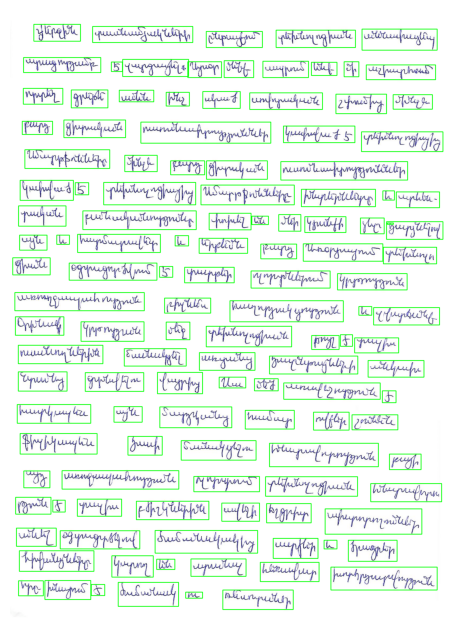

In [17]:
def merge_word_boxes(image_path, dilation_kernel=(20, 4)):
    """
    Detects and merges nearby text components in an image into word-level bounding boxes using dilation.

    Parameters:
        image_path (str): Path to the input image containing text.
        dilation_kernel (tuple): Size of the rectangular structuring element used for dilation.
                                 Wider kernels help merge nearby characters into words.

    Returns:
        List[Tuple[int, int, int, int]]: A list of bounding boxes in (x1, y1, x2, y2) format.
    """

    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, dilation_kernel)
    dilated = cv2.dilate(binary, kernel, iterations=1)

    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    bounding_boxes = []
    image_with_boxes = image.copy()

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, x + w, y + h))
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)

    image_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(image_rgb)
    plt.axis("off")
    plt.show()

    return bounding_boxes


final_boxes = merge_word_boxes(image_path)

In [18]:
def annotate_cropped_images(
    image_path,
    final_boxes,
    output_folder="cropped_words",
    annotation_file="annotations.tsv",
):
    """
    Crops word-level regions from an image using bounding boxes, saves them, and interactively collects labels.

    Parameters:
        image_path (str): Path to the original image from which words were detected.
        final_boxes (List[Tuple[int, int, int, int]]): List of bounding boxes in (x1, y1, x2, y2) format.
        output_folder (str): Folder to save the cropped word images. Defaults to 'cropped_words'.
        annotation_file (str): Path to the annotation TSV file to update or create. Defaults to 'annotations.tsv'.

    Returns:
        None
    """

    os.makedirs(output_folder, exist_ok=True)

    image = cv2.imread(image_path)
    image_name = os.path.splitext(os.path.basename(image_path))[0]

    cropped_filenames = []
    for i, box in enumerate(final_boxes):
        x1, y1, x2, y2 = map(int, box)
        cropped = image[y1:y2, x1:x2]
        cropped_filename = os.path.join(output_folder, f"{image_name}_word_{i+1}.png")
        cv2.imwrite(cropped_filename, cropped)
        cropped_filenames.append(cropped_filename)

    if os.path.exists(annotation_file):
        existing_df = pd.read_csv(annotation_file, sep="\t", encoding="utf-8")
    else:
        existing_df = pd.DataFrame(columns=["filename", "label"])

    annotations = []
    for cropped_filename in cropped_filenames:
        img = cv2.imread(cropped_filename)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

        label = input(
            "Enter Armenian label (or type 'bad' if the cut is not usable): "
        ).strip()
        annotations.append([cropped_filename, label])

    new_df = pd.DataFrame(annotations, columns=["filename", "label"])
    final_df = pd.concat([existing_df, new_df], ignore_index=True)

    final_df.to_csv(annotation_file, sep="\t", index=False, encoding="utf-8")

    print(f"Annotations updated in {annotation_file}")

When running the function call below, each word image is going to open asking the annotator to type in what they see on an image.

As mentioned, the final boxes may have some artifacts inside them (regardless of merging)
For that reason, the annotator can use the special word `bad` during the process when they face such an example. Later annotations can be filtered to exclude the bad examples both from the image folder and the annotations file.

In [ ]:
# image_path = path + fileName
annotate_cropped_images(image_path, final_boxes, annotation_file="annotations.tsv")

# Basic file cleaning

In this stage, the generated image folders and their respective annotations files are being cleaned to be consistent with one another while having no junk left in them (e.g bad annotation, a missing file after manually inspecting the folders and deleting some examples)

### real images

In [ ]:
annots = pd.read_csv("./capstone-htr/data_preparation/annotations.tsv", sep="\t")
len(annots[annots["label"].isin(["bad"]) | annots["label"].isna()])

In [ ]:
annots = pd.read_csv("./capstone-htr/data_preparation/annotations.tsv", sep="\t")
bad_annots = annots[annots["label"].isin(["bad"]) | annots["label"].isna()]
print(len(bad_annots))
for fname in bad_annots["filename"]:
    path = fname
    print(path)
    if os.path.exists(path):
        os.remove(path)

In [99]:
annots = annots[annots["label"].isin(["bad"]) | annots["label"].isna()]
annots.to_csv(
    "./capstone-htr/data_preparation/annotations_cleaned.tsv", sep="\t", index=False
)

### now for the synthetic images

In [ ]:
src_path = "./synthetic_words_refined/image_labels.tsv"
dst_path = "./synthetic_words_inverted/image_labels.tsv"

shutil.copyfile(src_path, dst_path)

In [78]:
os.chdir("./synthetic_words_inverted")

In [79]:
annots = pd.read_csv(
    "./image_labels.tsv", sep="\t"
)  # copy the labels file into this folder beforehand

In [ ]:
annots_filtered = annots[annots["filename"].apply(lambda x: os.path.exists(x))]
annots_filtered.to_csv("annotations_synthetic.tsv", sep="\t", index=False)
print(f"Original rows: {len(annots)}")
print(f"Rows after filtering: {len(annots_filtered)}")

In [ ]:
png_files = []

for root, dirs, files in os.walk("."):
    for file in files:
        if file.lower().endswith(".png"):
            full_path = os.path.join(root, file)
            png_files.append(full_path)

print(f"Total PNG files found: {len(png_files)}")

In [84]:
all_pngs_on_disk = []
for root, dirs, files in os.walk("."):
    for file in files:
        if file.lower().endswith(".png"):
            full_path = os.path.join(root, file)
            all_pngs_on_disk.append(os.path.relpath(full_path))

referenced_files = set(annots_filtered["filename"])

unreferenced_pngs = [f for f in all_pngs_on_disk if f not in referenced_files]

In [86]:
for file in unreferenced_pngs:
    if os.path.exists(file):
        os.remove(file)
        print(f"Deleted: {file}")
    else:
        print(f"Already missing: {file}")